# **Install all the package**

In [1]:
pip install pyorc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.3 MB/s eta 0:00:00


In [ ]:
pip install pyopenrivercam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:


In [ ]:
pip install cartopy

# **Setup a camera configuration for processing a single video**

In [ ]:
import xarray as xr
import pyorc
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Open video and plot the first frame

In [ ]:
# uncomment line below if you want to view coordinates interactively
#%matplotlib notebook
video_file = "DJI_0724.mp4"
video = pyorc.Video(video_file, start_frame=0, end_frame=1)  # we only need one frame
frame = video.get_frame(0, method="rgb")

# plot frame on a notebook-style window
f = plt.figure(figsize=(10, 6))
plt.imshow(frame)

 Identify different marker x (column) and y (row) positions in the camera’s objective

In [ ]:
%matplotlib inline
gcps = dict(
    src=[
        [1000, 650],
        [500, 2050],
        [2400, 500],
        [2400, 2000]
    ]
)

f = plt.figure(figsize=(16, 9))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.legend()

In [ ]:
# first add our UTM 48N coordinates. This MUST be in precisely the same order as the src coordinates.
gcps["dst"] = [
    [345710.799, 173726.075],  # lowest right coordinate
    [345710.690, 173730.608],  # highest right coordinate
    [345706.011, 173721.877],  # highest left coordinate
    [345702.902, 173730.945]  # highest left coordinate
]

# # if we would use this video as survey in video, the lines below are also needed,
# # and proper values need to be filled in. They are now commented out.
# gcps["h_ref"] = <your locally measured water level during survey in>
gcps["z_0"] = 32.31

# set the height and width
height, width = frame.shape[0:2]

# now we use everything to make a camera configuration
cam_config = pyorc.CameraConfig(height=height, width=width, gcps=gcps, crs=32648)

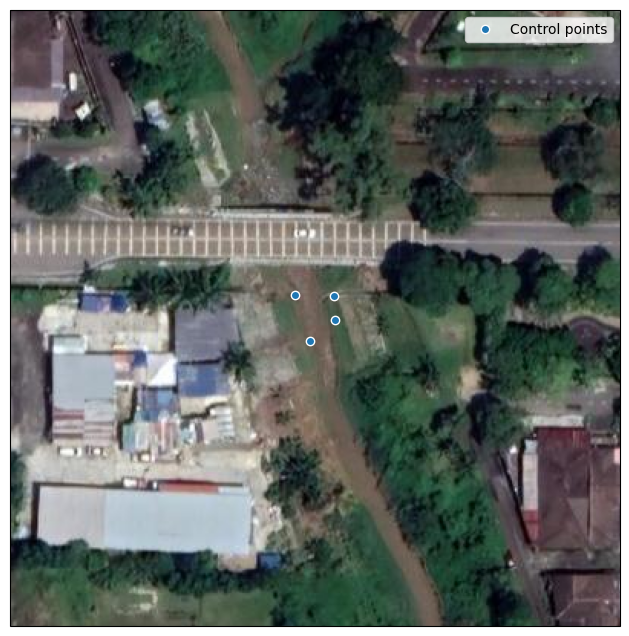

In [ ]:
ax = cam_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"})

Below we make a quick plot. Cartopy is used to make the plot geographically aware. We use GoogleTiles, using the satellite style.

In [ ]:
corners = [
    [300, 2000],
    [1000, 250],
    [3500, 1800],
    [3500, 650]
]
cam_config.set_bbox_from_corners(corners)
cam_config.resolution = 0.01
cam_config.window_size = 25

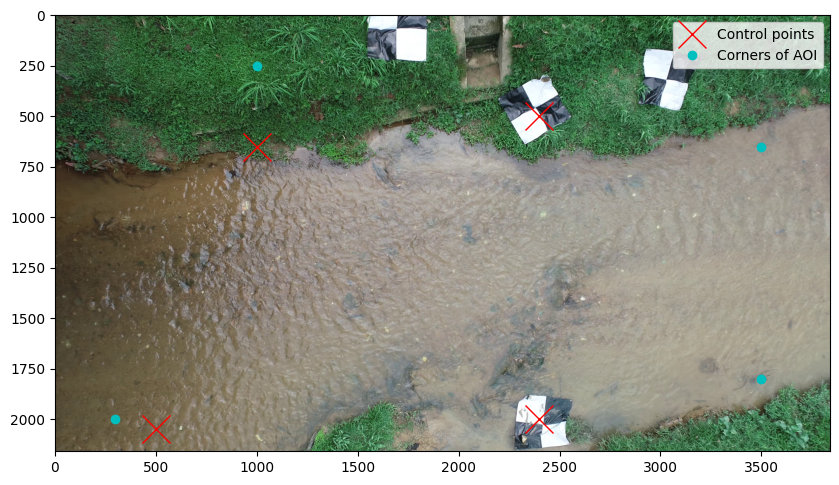

In [ ]:
f = plt.figure(figsize=(10, 6))
plt.imshow(frame)
plt.plot(*zip(*gcps["src"]), "rx", markersize=20, label="Control points")
plt.plot(*zip(*corners), "co", label="Corners of AOI")
plt.legend()

Now that all information is entered, we show the final camera configuration as a plot, both in geographical projection and in camera perspective.

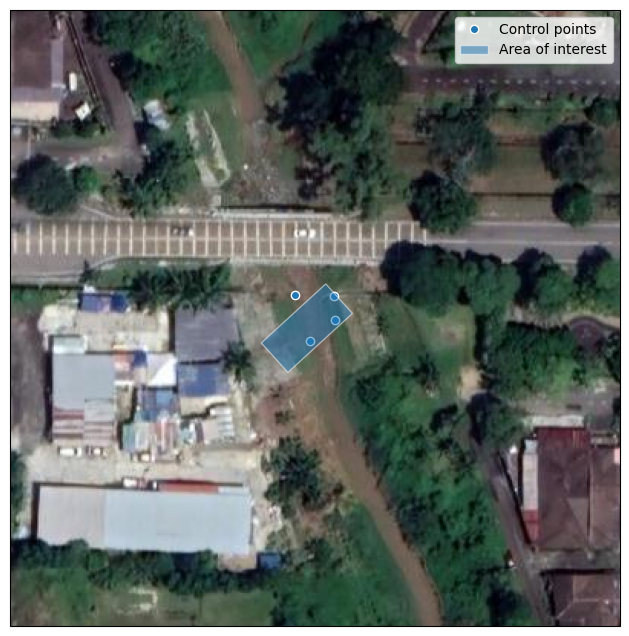

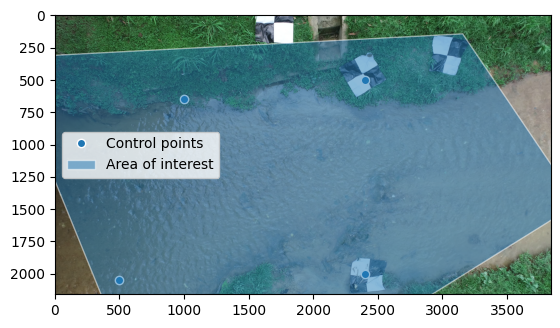

In [ ]:
%matplotlib inline

ax1 = cam_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"})

f = plt.figure()
ax2 = plt.axes()
ax2.imshow(frame)
cam_config.plot(ax=ax2, camera=True)

plt.savefig("ngwerere_camconfig.jpg", bbox_inches="tight", dpi=72)

In [ ]:
print(cam_config)
cam_config.to_file("ngwerere.json")

{
    "height": 2160,
    "width": 3840,
    "crs": "PROJCRS[\"WGS 84 / UTM zone 48N\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 48N\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8801]],PARAMETER[\"Longitude of natural origin\",105,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8802]],PARAMETER[\"Scale factor at natural origin\",0.999

**Analyze surface velocities of a video with velocimetry**

In [ ]:
import pyorc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from dask.diagnostics import ProgressBar

# Load our camera configuration

In [ ]:
cam_config = pyorc.load_camera_config("ngwerere.json")
video_file = "DJI_0724.mp4"
# set coordinates that encapsulate the water surface at minimum. Areas outside will be used for stabilization
stabilize = [
    [150, 0],
    [500, 1750],
    [3500, 1750],
    [3500, 0]
]
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=125,
    stabilize=stabilize,
    h_a=0.
)
video

In [ ]:
da = video.get_frames()
da

# **Extracting gray scaled frame**

In [ ]:
da[0].plot(cmap="gray")

# **Normalize to add contrast**

In [ ]:
da_norm = da.frames.normalize()
da_norm[0].frames.plot(cmap="gray")

<Figure size 1600x900 with 0 Axes>

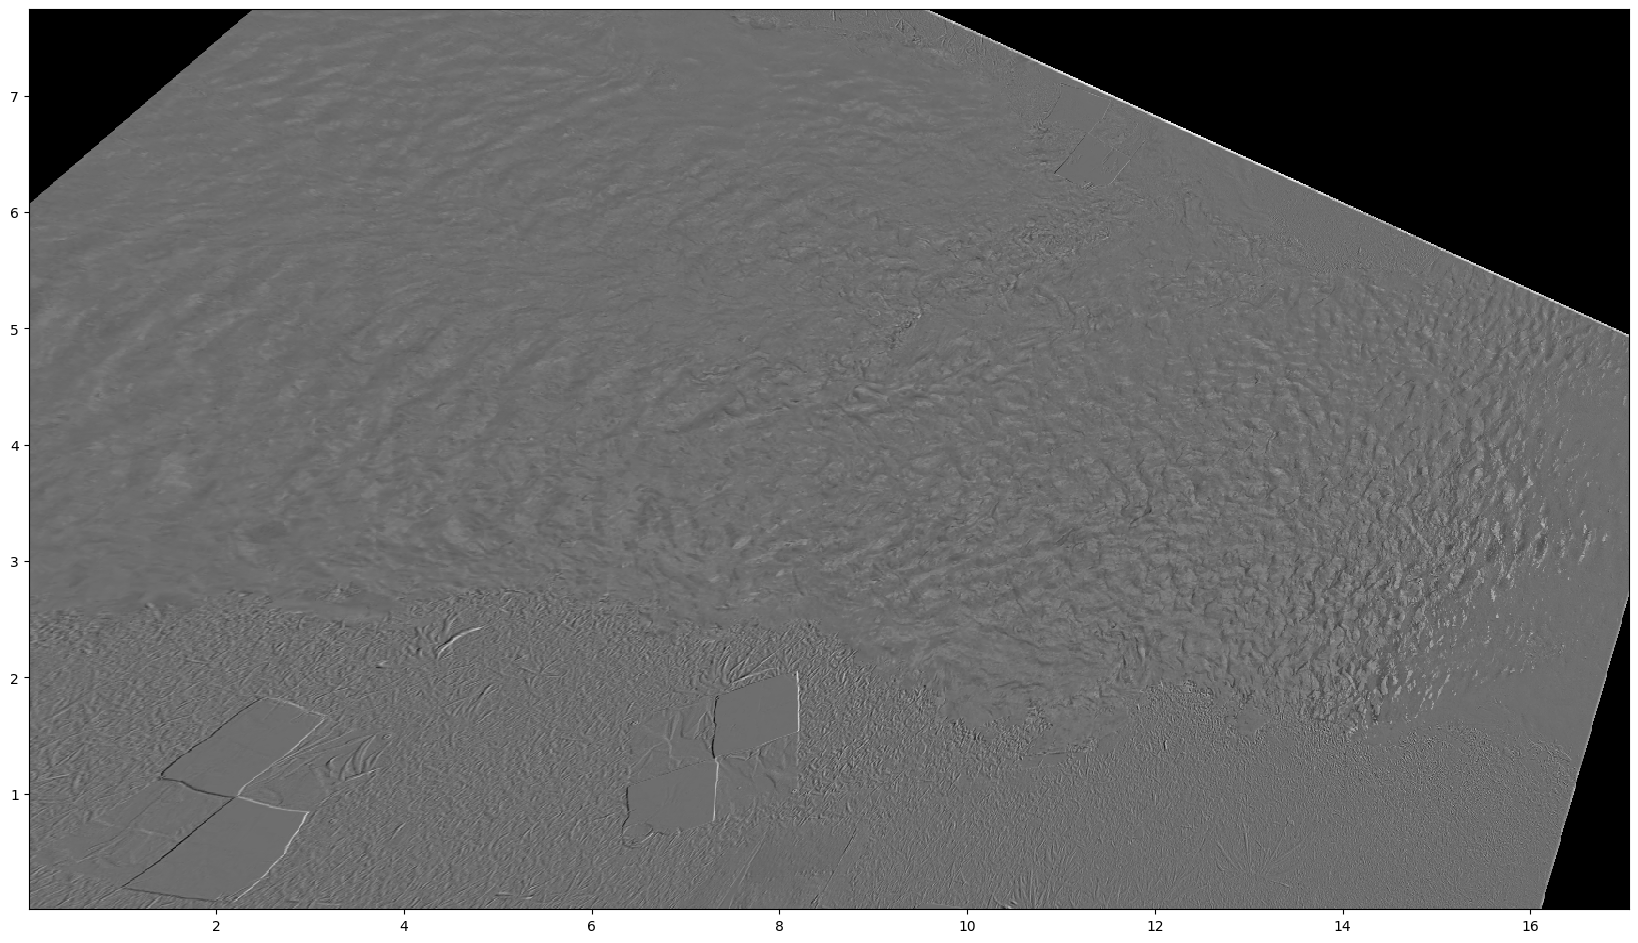

In [ ]:
f = plt.figure(figsize=(16, 9))
da_norm_proj = da_norm.frames.project()
da_norm_proj[0].frames.plot(cmap="gray")

In [ ]:
# extract frames again, but now with rgb
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()
# plot the first frame in geographical mode
p = da_rgb_proj[0].frames.plot(mode="geographical")

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.0001,
    da_rgb_proj.lon.max() + 0.0001,
    da_rgb_proj.lat.min() - 0.0001,
    da_rgb_proj.lat.max() + 0.0001],
    crs=ccrs.PlateCarree()
)


# **Velocimetry estimates**

In [ ]:
piv = da_norm_proj.frames.get_piv()
delayed_obj = piv.to_netcdf("ngwerere_piv.nc", compute=False)
with ProgressBar():
    results = delayed_obj.compute()

[########################################] | 100% Completed | 13m 15s


# **Plotting and analyzing results**

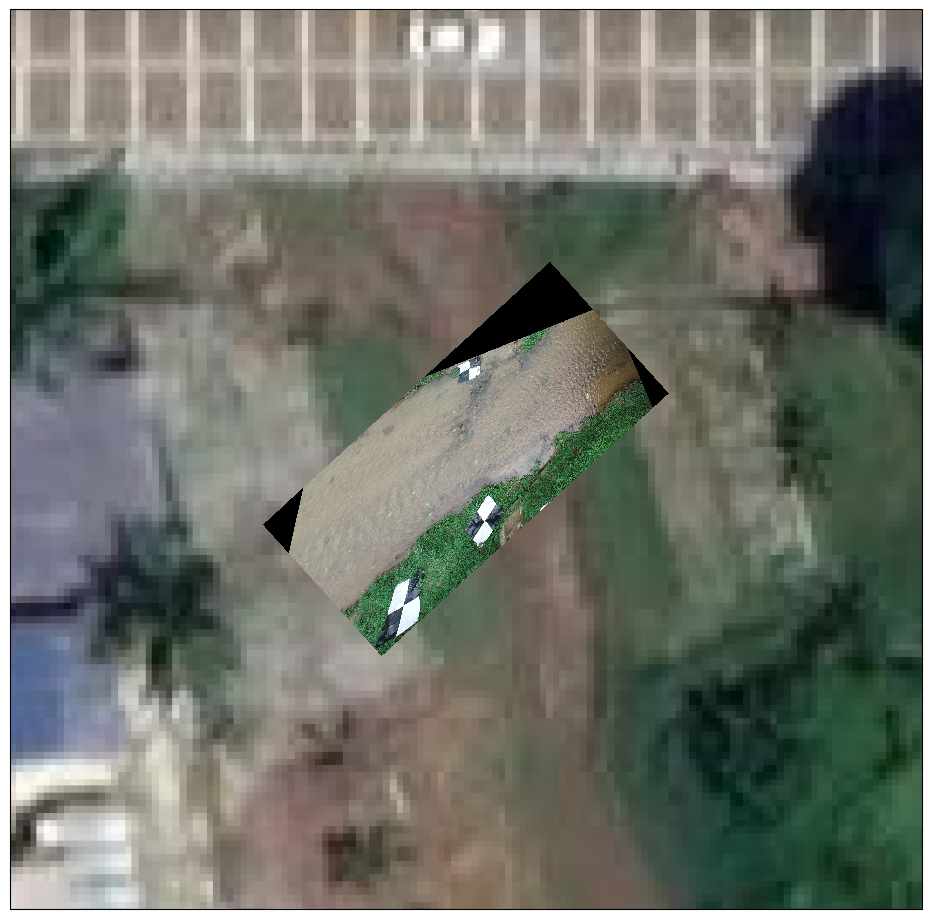

In [ ]:
# extract frames again, but now with rgb
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()
# plot the first frame in geographical mode
p = da_rgb_proj[0].frames.plot(mode="geographical")

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.0001,
    da_rgb_proj.lon.max() + 0.0001,
    da_rgb_proj.lat.min() - 0.0001,
    da_rgb_proj.lat.max() + 0.0001],
    crs=ccrs.PlateCarree()
)

In [ ]:
import xarray as xr
import pyorc
from matplotlib.colors import Normalize

In [ ]:
ds = xr.open_dataset("ngwerere_piv.nc")
ds

<xarray.Dataset>
Dimensions:  (time: 125, y: 58, x: 130)
Coordinates:
  * time     (time) float64 0.03337 0.06673 0.1001 0.1335 ... 4.104 4.137 4.171
  * y        (y) float64 7.475 7.345 7.215 7.085 ... 0.455 0.325 0.195 0.065
  * x        (x) float64 0.065 0.195 0.325 0.455 ... 16.45 16.58 16.71 16.84
    xp       (y, x) float32 ...
    yp       (y, x) float32 ...
    xs       (y, x) float64 ...
    ys       (y, x) float64 ...
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Data variables:
    v_x      (time, y, x) float32 ...
    v_y      (time, y, x) float32 ...
    s2n      (time, y, x) float32 ...
    corr     (time, y, x) float32 ...
Attributes:
    camera_shape:   [2160, 3840]
    camera_config:  {\n    "height": 2160,\n    "width": 3840,\n    "crs": "P...
    h_a:            0.0

# **Plotting in local projection**

In [ ]:
# first re-open the original video, extract one RGB frame and plot that
video_file = "DJI_0724.mp4"

video = pyorc.Video(video_file, start_frame=0, end_frame=125)
# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

da_rgb = video.get_frames(method="rgb")
# project the rgb frame
da_rgb_proj = da_rgb.frames.project()
# plot the first frame (we only have one) without any arguments, default is to use "local" mode
p = da_rgb_proj[0].frames.plot()

# now plot the results on top, we use the mean, because we cannot plot more than 2 dimensions.
# Default plotting method is "quiver", but "scatter" or "pcolormesh" is also possible.
# We add a nice colorbar to understand the magnitudes.
# We give the existing axis handle of the mappable returned from .frames.plot to plot on, and use
# some transparency.
ds_mean = ds.mean(dim="time", keep_attrs=True)

# first a pcolormesh
ds_mean.velocimetry.plot.pcolormesh(
    ax=p.axes,
    alpha=0.3,
    cmap="rainbow",
    add_colorbar=True,
    vmax=0.6
)

ds_mean.velocimetry.plot(
    ax=p.axes,
    color="w",
    alpha=0.5,
    width=0.0015,
)


In [ ]:
import copy
ds_mask = copy.deepcopy(ds)
mask_corr = ds_mask.velocimetry.mask.corr(inplace=True)
mask_minmax = ds_mask.velocimetry.mask.minmax(inplace=True)
mask_rolling = ds_mask.velocimetry.mask.rolling(inplace=True)
mask_outliers = ds_mask.velocimetry.mask.outliers(inplace=True)
mask_var = ds_mask.velocimetry.mask.variance(inplace=True)
mask_angle = ds_mask.velocimetry.mask.angle(inplace=True)
mask_count = ds_mask.velocimetry.mask.count(inplace=True)


# apply the plot again, let's leave out the scalar values, and make the quivers a bit nicer than before.
ds_mean_mask = ds_mask.mean(dim="time", keep_attrs=True)


# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then masked velocimetry
ds_mean_mask.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    cmap="rainbow",
    scale=20,
    width=0.0015,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)

In [ ]:
# apply all methods in time domain with relaxed angle masking
import numpy as np
ds_mask2 = copy.deepcopy(ds)
ds_mask2.velocimetry.mask.corr(inplace=True)
ds_mask2.velocimetry.mask.minmax(inplace=True)
ds_mask2.velocimetry.mask.rolling(inplace=True)
ds_mask2.velocimetry.mask.outliers(inplace=True)
ds_mask2.velocimetry.mask.variance(inplace=True)
ds_mask2.velocimetry.mask.angle(angle_tolerance=0.5*np.pi)
ds_mask2.velocimetry.mask.count(inplace=True)
ds_mask2.velocimetry.mask.window_mean(wdw=2, inplace=True, tolerance=0.5, reduce_time=True)

# Now first average in time before applying any filter that only works in space.
ds_mean_mask2 = ds_mask2.mean(dim="time", keep_attrs=True)



# apply the plot again
# again the rgb frame first
p = da_rgb_proj[0].frames.plot()

#...and then filtered velocimetry
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    alpha=0.4,
    cmap="rainbow",
    scale=20,
    width=0.0015,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)

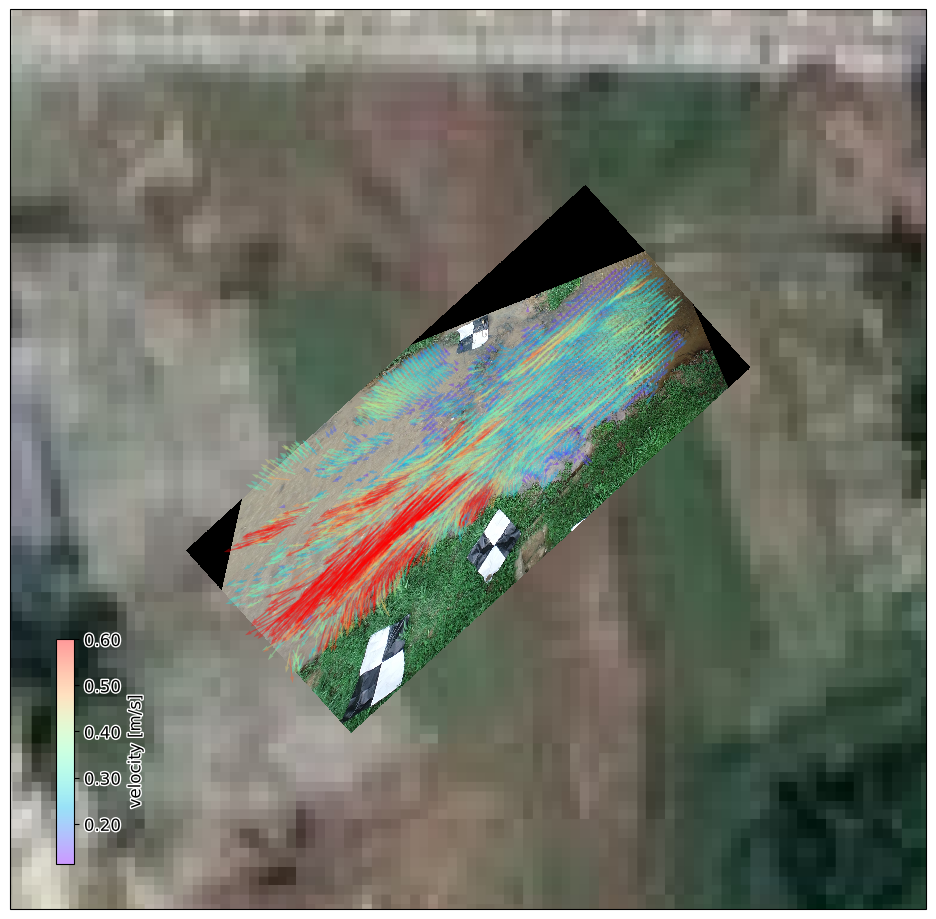

In [ ]:
# again the rgb frame first. But now we use the "geographical" mode to plot on a map
p = da_rgb_proj[0].frames.plot(mode="geographical")

#...and then masked velocimetry again, but also geographical
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    mode="geographical",
    alpha=0.4,
    cmap="rainbow",
    scale=20,
    width=0.0015,
    norm=Normalize(vmax=0.6, clip=False),
    add_colorbar=True
)
# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.00005,
    da_rgb_proj.lon.max() + 0.00005,
    da_rgb_proj.lat.min() - 0.00005,
    da_rgb_proj.lat.max() + 0.00005],
    crs=ccrs.PlateCarree()
)


# **Immersive and intuitive augmented reality**

In [ ]:
# again the rgb frame first, but now the unprojected one. Now we use the "camera" mode to plot the camera perspective
p = da_rgb[0].frames.plot(mode="camera")

#...and then masked velocimetry again, but also camera. This gives us an augmented reality view. The quiver scale
# needs to be adapted to fit in the screen properly
ds_mean_mask2.velocimetry.plot(
    ax=p.axes,
    mode="camera",
    alpha=0.4,
    cmap="rainbow",
    scale=200,
    width=0.0015,
    norm=Normalize(vmin=0., vmax=1.0, clip=False),
    add_colorbar=True
)

In [ ]:
ds_mask2.velocimetry.set_encoding()
ds_mask2.to_netcdf("ngwerere_masked.nc")

# **Obtain a discharge measurement over a cross section**

In [ ]:
import xarray as xr
import pandas as pd
import pyorc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [ ]:
ds = xr.open_dataset("ngwerere_masked.nc")

# also open the original video file
video_file = "DJI_0724.mp4"
video = pyorc.Video(video_file, start_frame=0, end_frame=1)

# borrow the camera config from the velocimetry results
video.camera_config = ds.velocimetry.camera_config

# get the frame as rgb
da_rgb = video.get_frames(method="rgb")

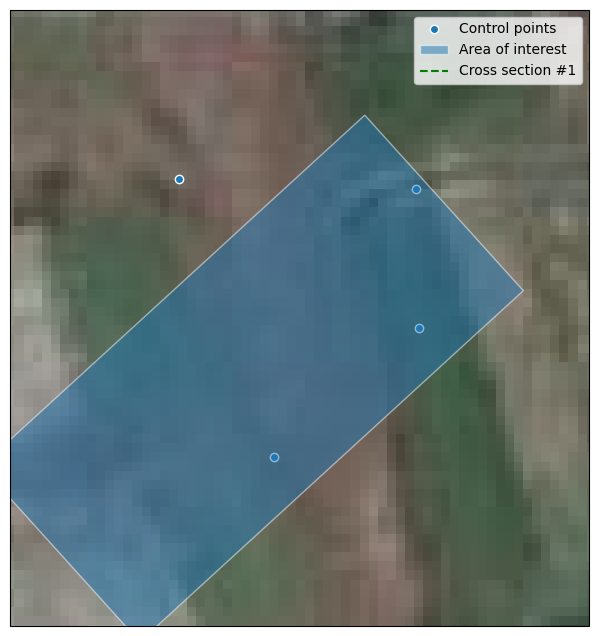

In [ ]:
cross_section = pd.read_csv("river_teratai.csv")
x = cross_section["x"]
y = cross_section["y"]
z = cross_section["z"]

# let's have a look at the cross sections, the coordinates of the cross sections are in UTM 35S coordinates,
# so we have to tell the axes that the coordinates need to be transformed from that crs into the crs of the axes.
# we also make a very very small buffer of 0.00005 degrees around the area of interest, so that we can
# clearly see the cross sections.
ax = ds.velocimetry.camera_config.plot(tiles="GoogleTiles", tiles_kwargs={"style": "satellite"}, buffer=0.00005)
ax.plot(x, y, "g--", transform=ccrs.UTM(zone=35, southern_hemisphere=True), label="Cross section #1")
ax.legend()

In [ ]:
ds_points = ds.velocimetry.get_transect(x, y, z, crs=32648, rolling=4)
ds_points

<xarray.Dataset>
Dimensions:       (points: 31, quantile: 5)
Coordinates: (12/13)
    xp            (points) float64 1.269e+03 1.309e+03 ... 2.065e+03 2.101e+03
    yp            (points) float64 1.094e+03 1.074e+03 1.054e+03 ... 401.6 384.3
    xs            (points) float64 3.457e+05 3.457e+05 ... 3.457e+05 3.457e+05
    ys            (points) float64 1.737e+05 1.737e+05 ... 1.737e+05 1.737e+05
    lon           (points) float64 103.6 103.6 103.6 103.6 ... 103.6 103.6 103.6
    lat           (points) float64 1.571 1.571 1.571 1.571 ... 1.571 1.571 1.571
    ...            ...
    y             (points) float64 2.646 2.733 2.82 2.908 ... 5.242 5.33 5.417
    xcoords       (points) float64 3.457e+05 3.457e+05 ... 3.457e+05 3.457e+05
    ycoords       (points) float64 1.737e+05 1.737e+05 ... 1.737e+05 1.737e+05
    scoords       (points) float64 0.0 0.13 0.26 0.39 ... 3.51 3.64 3.77 3.9
    zcoords       (points) float64 32.36 32.99 32.57 32.62 ... 31.9 31.93 31.96
  * quantile      (quantile) float64 0.05 0.25 0.5 0.75 0.95
Dimensions without coordinates: points
Data variables:
    v_x           (quantile, points) float64 -0.3258 -0.3281 -0.3256 ... nan nan
    v_y           (quantile, points) float64 -0.03861 -0.04733 ... nan nan
    s2n           (quantile, points) float64 1.001 1.001 1.0 ... 1.001 nan nan
    corr          (quantile, points) float64 0.309 0.3119 0.3121 ... nan nan
    cols          (points) float64 103.4 102.6 101.9 101.2 ... 92.83 92.09 91.35
    rows          (points) float64 37.65 36.98 36.3 35.63 ... 17.67 17.0 16.33
    v_dir         (points) float64 -2.404 -2.404 -2.404 ... -2.404 -2.404 -2.404
    v_eff_nofill  (quantile, points) float64 0.2476 0.2556 0.2568 ... nan nan
Attributes:
    camera_shape:   [2160, 3840]
    camera_config:  {\n    "height": 2160,\n    "width": 3840,\n    "crs": "P...
    h_a:            0.0

In [ ]:
ds_points_q = ds_points.transect.get_q(fill_method="log_interp")
ds_points_q

<xarray.Dataset>
Dimensions:       (points: 31, quantile: 5)
Coordinates: (12/13)
    xp            (points) float64 1.269e+03 1.309e+03 ... 2.065e+03 2.101e+03
    yp            (points) float64 1.094e+03 1.074e+03 1.054e+03 ... 401.6 384.3
    xs            (points) float64 3.457e+05 3.457e+05 ... 3.457e+05 3.457e+05
    ys            (points) float64 1.737e+05 1.737e+05 ... 1.737e+05 1.737e+05
    lon           (points) float64 103.6 103.6 103.6 103.6 ... 103.6 103.6 103.6
    lat           (points) float64 1.571 1.571 1.571 1.571 ... 1.571 1.571 1.571
    ...            ...
    y             (points) float64 2.646 2.733 2.82 2.908 ... 5.242 5.33 5.417
    xcoords       (points) float64 3.457e+05 3.457e+05 ... 3.457e+05 3.457e+05
    ycoords       (points) float64 1.737e+05 1.737e+05 ... 1.737e+05 1.737e+05
    scoords       (points) float64 0.0 0.13 0.26 0.39 ... 3.51 3.64 3.77 3.9
    zcoords       (points) float64 32.36 32.99 32.57 32.62 ... 31.9 31.93 31.96
  * quantile      (quantile) float64 0.05 0.25 0.5 0.75 0.95
Dimensions without coordinates: points
Data variables:
    v_x           (quantile, points) float64 -0.3258 -0.3281 -0.3256 ... nan nan
    v_y           (quantile, points) float64 -0.03861 -0.04733 ... nan nan
    s2n           (quantile, points) float64 1.001 1.001 1.0 ... 1.001 nan nan
    corr          (quantile, points) float64 0.309 0.3119 0.3121 ... nan nan
    cols          (points) float64 103.4 102.6 101.9 101.2 ... 92.83 92.09 91.35
    rows          (points) float64 37.65 36.98 36.3 35.63 ... 17.67 17.0 16.33
    v_dir         (points) float64 -2.404 -2.404 -2.404 ... -2.404 -2.404 -2.404
    v_eff_nofill  (quantile, points) float64 0.0 0.0 0.0 0.0 ... 0.1082 nan nan
    v_eff         (quantile, points) float64 0.0 0.0 0.0 0.0 ... 0.1082 nan nan
    q_nofill      (quantile, points) float64 0.0 0.0 0.0 0.0 ... 0.04014 nan nan
    q             (quantile, points) float64 0.0 0.0 0.0 0.0 ... 0.04014 nan nan
Attributes:
    camera_shape:   [2160, 3840]
    camera_config:  {\n    "height": 2160,\n    "width": 3840,\n    "crs": "P...
    h_a:            0.0

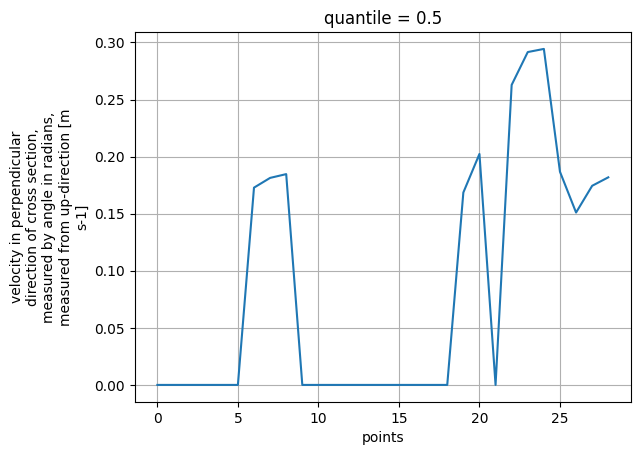

In [ ]:
ax = plt.axes()
ds_points_q["v_eff"].isel(quantile=2).plot(ax=ax)
plt.grid()

We can also plot the sampled surface velocities in combination with the velocity grid with bespoke plotting functions, giving intuitive graphics.

# **Ploting our results in a local projection**

In [ ]:
# plot the rgb frame first. We use the "camera" mode to plot the camera perspective.
norm = Normalize(vmin=0., vmax=0.6, clip=False)

p = da_rgb[0].frames.plot(mode="camera")

# extract mean velocity and plot in camera projection
ds.mean(dim="time", keep_attrs=True).velocimetry.plot(
    ax=p.axes,
    mode="camera",
    cmap="rainbow",
    scale=200,
    width=0.001,
    alpha=0.3,
    norm=norm,
)

# plot velocimetry point results in camera projection
ds_points_q.isel(quantile=2).transect.plot(
    ax=p.axes,
    mode="camera",
    cmap="rainbow",
    scale=100,
    width=0.003,
    norm=norm,
)

# store figure in a JPEG
p.axes.figure.savefig("ngwerere.jpg", dpi=200)

In [ ]:
# again plot the projected background
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=0.6, clip=False)
ds_mean = ds.mean(dim="time", keep_attrs=True)
p = da_rgb.frames.project()[0].frames.plot(mode="local")

# plot velocimetry point results in local projection
ds_points_q.isel(quantile=2).transect.plot(
    ax=p.axes,
    mode="local",
    cmap="rainbow",
    scale=10,
    width=0.003,
    norm=norm,
    add_colorbar=True,
)

# to ensure streamplot understands the directions correctly, all values must
# be flipped upside down and up-down velocities become down-up velocities.
ds_mean.velocimetry.plot.streamplot(
    ax=p.axes,
    mode="local",
    density=3.,
    minlength=0.05,
    linewidth_scale=2,
    cmap="rainbow",
    norm=norm,
    add_colorbar=True
)

# **Finally, we can extract discharge estimates from the cross section**

In [ ]:
ds_points_q.transect.get_river_flow()
print(ds_points_q["river_flow"])


<xarray.DataArray 'river_flow' (quantile: 5)>
array([0.19216729, 0.14143189, 0.10597735, 0.07840356, 0.04907042])
Coordinates:
  * quantile  (quantile) float64 0.05 0.25 0.5 0.75 0.95
Attributes:
    standard_name:  river_discharge
    long_name:      River Flow
    units:          m3 s-1
